# Scraping British Airway Reviews BeautifulSoup4

## Import Packages

In [129]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from time import sleep

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
#import graphviz




from sklearn import preprocessing

## Collecting Data by BeautifulSoup4 Web Scraping

### Reviewing website scraping policies: Skytrax allows web scraping within their preset parameters

In [123]:
#url that contains robot.txt
url = 'https://www.airlinequality.com/robots.txt'

response = requests.get(url)

if response.status_code == 200:
    rules = response.text
elif response.status_code == 404:
    rules = ''
else:
    rules = f'other: {response.status_code}'

#print skytrax webscraping policies
print(rules)

User-agent: Scrapy
Allow: /

# Termly scanner
User-agent: TermlyBot
Allow: /

User-agent: *
Disallow: /go/

User-agent: *
Disallow: /wp-admin/
Crawl-delay: 5

Sitemap: https://www.airlinequality.com/sitemap.xml


### Successfuly scraped all reviews and tables into one dataframe (df_scrape)

In [183]:
base_url = 'https://www.airlinequality.com/airline-reviews/british-airways/'

# empty list to collect data
scraped_data = []
# page count variable keeps track of page being looped
page_count = 0
# review_count keeps track of total reviews looped through
review_count = 0



for page in range(1, 396):  
    url = f'{base_url}page/{page}/'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    
    # Extract data from each page
    feedbacks = soup.find_all('article',class_= 'comp')

    page_count+=1
    # review_number keeps track of the review number on the page
    review_number = 0
    for feedback in feedbacks:
        # empty dictionary to add each element to be scraped from each review
        data = {}
                
        # rating from 1-10 saved as text and added to data disctionary
        rating = feedback.find(class_='rating-10')
        data['rating'] = rating.text if rating else ''
        
        # date of flight added to dictionary saved and added to dictionary
        time = feedback.find('time')
        data['time'] = time.text if time else ''
        
        # demographic data collected from reviewer saved and added to dictionary
        demographic = feedback.find(class_='text_sub_header')
        data['demographic'] = demographic.text if demographic else ''
                
        # written comment and whether review verified saved and added to dictionary                
        comment = feedback.find(class_='text_content')                
        data['comment'] = comment.text if comment else ''
        
        # searches each section of 'table' element to scrape more granular data about flight
        rows = feedback.find_all('tr') 
                              
        # for loop cycles through each section of table element
        for row in rows:
            # the name of the data being collected
            col = row.find(class_='review-rating-header')
                    
            # the actual feedback has two classes, string feedback or 'star' integer (1-5), string is default
            val = row.find('td',class_='review-value')
                    
            # if clause that designates if no string value is saved in val
            if val == None:
                    list_size = len(row.find_all('span', class_='star fill'))
                    if list_size == 0: continue
                    
                    else:
                        val_current = row.find_all('span', class_='star fill')
                        val = row.find_all('span', class_='star fill')[-1]
                    
            # adds the section into the data dictionary    
            data[col.text if col else ''] = val.text if val else ''
        #append the data to the empty list
        scraped_data.append(data)
        review_count+=1
        review_number+=1
        #sleep(0.1)

In [ ]:
# reviewing to see all pages and reviews were saved successfully
print('review ',review_count)
print('page ',page_count)

review  4732
page  395


Saving the scrape output as a pandas data fame

In [187]:
# current (05/29/25) variable
df_scrape = pd.DataFrame.from_dict(scraped_data)
df_scrape.head(3)

,rating,time,demographic,comment,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,Recommended,Aircraft
0,\n2/10\n,27th May 2025,\n\nR Williams (United Kingdom) 27th May 2025,Not Verified | This recent long-haul experien...,Family Leisure,Economy Class,Dubai to London Heathrow,April 2025,1,1,1,1,1,1,1,no,Boeing 777
1,\n2/10\n,27th May 2025,\n\nR Williams (United Kingdom) 27th May 2025,Not Verified | This recent long-haul experien...,Business,Economy Class,Shanghai to London Heathrow,May 2025,1,1,1,3,1,3,1,no,NaN
2,\n6/10\n,20th May 2025,\n\nMichael Little (Australia) 20th May 2025,✅ Trip Verified | Check-in was slow with onl...,Couple Leisure,Economy Class,Porto to Gatwick,April 2025,4,4,2,NaN,3,NaN,5,yes,A320


## Data Preprocessing

### Cleaning and processing data

In [188]:
df_scrape.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4732 entries, 0 to 4731
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   rating                  4732 non-null   object
 1   time                    4732 non-null   object
 2   demographic             4732 non-null   object
 3   comment                 4732 non-null   object
 4   Type Of Traveller       3489 non-null   object
 5   Seat Type               4335 non-null   object
 6   Route                   3484 non-null   object
 7   Date Flown              3481 non-null   object
 8   Seat Comfort            4210 non-null   object
 9   Cabin Staff Service     4195 non-null   object
 10  Food & Beverages        3892 non-null   object
 11  Inflight Entertainment  3073 non-null   object
 12  Ground Service          3409 non-null   object
 13  Wifi & Connectivity     970 non-null    object
 14  Value For Money         4336 non-null   object
 15  Reco

In [190]:
# making a clean df to not compromise original df
df_clean = df_scrape.copy()

In [191]:
# code produced a duplicate review for first review of page that had incorrect values, since this was a consistent error it can be excluded by dropping every twelth row
scrape_clean = df_clean.iloc[::12,:].index
df_clean.drop(scrape_clean,inplace=True)

# drops all nan rows in df
df_clean.dropna(axis=0,thresh=5, inplace=True)

In [194]:
# need to impute NaN values first before converting to integer so converted to float first to be able to view the distr hist
df_clean[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
       'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity',
       'Value For Money']] = df_clean[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
       'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity',
       'Value For Money']].apply(pd.to_numeric)


In [ ]:
# uses reg expression to isolate rating of review
df_clean['rating'] = df_clean['rating'].str.extract(r'([0-9]+)')

In [208]:
# there are around 4 rows that do not have a rating, since the rows are missing majority of information they will most likely be of little use in analysis so these rows were dropped
df_clean[df_clean['rating'].isnull()]
print(len(df_clean[df_clean['rating'].isnull()]))
df_clean.dropna(subset='rating', inplace=True)

5


In [209]:
# changing datatype of rating to numeric
df_clean['rating'] = df_clean['rating'].astype(int)

In [210]:
# removing day suffix to make time variable a datetime datatype (change cheeto)
df_clean['time'] = df_clean['time'].str.replace('th','',regex=True)
df_clean['time'] = df_clean['time'].str.replace('nd','',regex=True)
df_clean['time'] = df_clean['time'].str.replace('rd','',regex=True)
df_clean['time'] = df_clean['time'].str.replace('1st','1',regex=True)

df_clean['time'] = pd.to_datetime(df_clean['time'], dayfirst=True)

In [211]:
# uses reg expression to isolate all within the parenthesis(country where reviewer live)
df_clean['country_residence'] = df_clean['demographic'].str.extract(r'\((.+)\)')

In [214]:
# using regex with extraxt to feature engineer variable on whether or not reviewer is verified
df_clean['verified'] = df_clean['comment'].str.extract(r'([A-Za-z ]* [A-Za-z]+erified)')
df_clean['verified'] = df_clean['verified'].str.strip()

# replacing inconsistent words in verified column with either not verified or verified
df_clean['verified'] = df_clean['verified'].str.replace('Trip Verified','Verified')
df_clean['verified'] = df_clean['verified'].str.replace('cNot Verified','Not Verified')
df_clean['verified'] = df_clean['verified'].str.replace('Unverified','Not Verified')

# ensuring all words in column are consistent
df_clean['verified'].value_counts() #Ensuring that the correct outputs are present not/verified

verified
Verified        2099
Not Verified     319
Name: count, dtype: int64

In [215]:
df_clean['comment'].str[:20]

1       Not Verified |  This
2       ✅ Trip Verified |   
3       Not Verified |  Chec
4       ✅ Trip Verified | Al
5       ✅ Trip Verified |   
                ...         
4724    Flew LHR - VIE retur
4725    LHR to HAM. Purser a
4726    My son who had worke
4729    London City-New York
4730    SIN-LHR BA12 B747-43
Name: comment, Length: 3937, dtype: object

In [232]:
# removing verification info from comment
vvv = df_clean['comment'].str.replace(r'\W*[A-Za-z ]+Verified\s\|','',regex=True).str.strip()

vvb = vvv.str.replace(r'[A-Z]{3}','',regex=True).str.strip()
vvb.str.replace(r'-','',regex=True).str.strip()

1       This recent longhaul experience was disappoint...
2       Checkin was slow with only one staff member ch...
3       Check in was smooth enough. Boarding was chaot...
4       Although transferring to this flight through H...
5       We are extremely grateful to the crew of fligh...
                              ...                        
4724    Flew    return operated by bmi but BA aircraft...
4725    to . Purser addresses all club passengers by n...
4726    My son who had worked for British Airways urge...
4729    London CityNew York  via Shannon on A318 but h...
4730    BA12 B747436 First Class. Old aircraft (1998) ...
Name: comment, Length: 3937, dtype: object

In [ ]:
# removing verification info from comment
df_clean['comment'] = df_clean['comment'].str.replace(r'\W*[A-Za-z ]+Verified\s\|','',regex=True).str.strip()

# removes unnecessary flight information and dashes
df_clean['comment'] = df_clean['comment'].str.replace(r'[A-Z]{3}','',regex=True).str.strip()
df_clean['comment'] = df_clean['comment'].str.replace(r'-','',regex=True).str.strip()
df_clean['comment'] = df_clean['comment'].str.replace(r'British Airway','',regex=False).str.strip()
df_clean['comment'] = df_clean['comment'].str.replace(r'BA','',regex=False).str.strip()
df_clean['comment'] = df_clean['comment'].str.replace(r'-','',regex=True).str.strip()


# removing lingering verification info
#df_clean['comment'] = df_clean['comment'].str.replace('Not Verified |', '')

## Descriptive Statistics of Data

In [125]:
df_clean.describe()

,rating,time,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Inflight Entertainment,Wifi & Connectivity
count,3935.000000,3935,3935.000000,3793.000000,3935.000000,3935.000000,3935.000000,2671.000000,695.000000
mean,4.665565,2018-02-19 22:59:15.171537664,2.860229,3.230424,2.738755,2.808386,2.655909,2.653688,1.939568
min,1.000000,2011-10-09 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2015-09-19 12:00:00,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000
50%,4.000000,2017-04-15 00:00:00,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000
75%,8.000000,2019-10-07 12:00:00,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,3.000000
max,10.000000,2025-05-20 00:00:00,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
std,3.178069,NaN,1.342013,1.494417,1.356361,1.301081,1.465421,1.400998,1.340707


## Data Visualization

### Data Exploration

Text(0.5, 1.0, 'British Airline Rating Distribution')

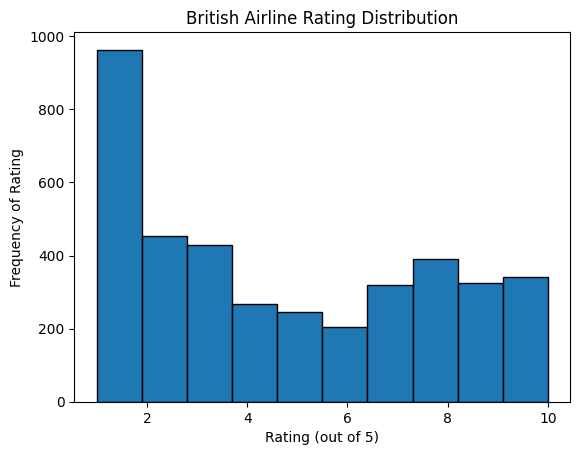

In [ ]:
# histogram to view rating distribution
df_clean['rating'].hist(grid=False, edgecolor = 'black')
plt.xlabel('Rating (out of 5)')
plt.ylabel('Frequency of Rating')
plt.title('British Airline Rating Distribution')

<Axes: ylabel='rating'>

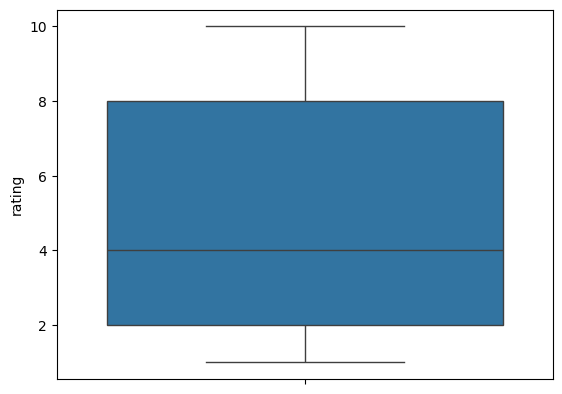

In [ ]:
# rating box plot
sns.boxplot(df_clean['rating'])

In [ ]:
# Finding missing value and its percentage
missing_values = df_clean.isna().sum()
missing_values_percent = (missing_values/len(df_clean))*100

Aircraft has inconsistent values in how the name and numbers were inputted by reviewer. May be impractical to try to extract or standardize. Route also either uses the city names or the airport acronym

In [ ]:
# Looping over titanic df columns and using .unique method
for c in df_clean.keys():
    print(f"Unique values in column '{c}':")
    print(df_clean[c].unique())
    print("\n")

Unique values in column 'rating':
[ 6  4  8 10  3  5  1  7  9  2]


Unique values in column 'time':
<DatetimeArray>
['2025-05-20 00:00:00', '2025-05-18 00:00:00', '2025-05-15 00:00:00',
 '2025-05-08 00:00:00', '2025-04-29 00:00:00', '2025-04-22 00:00:00',
 '2025-04-18 00:00:00', '2025-04-16 00:00:00', '2025-04-15 00:00:00',
 '2025-04-13 00:00:00',
 ...
 '2014-05-05 00:00:00', '2014-05-04 00:00:00', '2014-05-03 00:00:00',
 '2014-04-30 00:00:00', '2012-08-30 00:00:00', '2012-08-29 00:00:00',
 '2012-08-28 00:00:00', '2011-10-12 00:00:00', '2011-10-11 00:00:00',
 '2011-10-09 00:00:00']
Length: 2005, dtype: datetime64[ns]


Unique values in column 'demographic':
['\n\nMichael Little (Australia) 20th May 2025'
 '\n\nJ Tydeman (United Kingdom) 18th May 2025'
 '\n\nA Norton (United States) 15th May 2025' ...
 '\n\nAvril Barclay (United Kingdom) 12th October 2011'
 '\n\nC Volz (United States) 11th October 2011'
 '\n\nRuss King (United Kingdom) 9th October 2011']


Unique values in column 'comme

Seat type only has two missing values, so will investigate and drop these two reviews if necessary. Aircraft, Wifi, and Verification status (may need to investigate) all have around 50% or more mising values so it may be best to drop these columns entirely. Date Flown , Type of Traveller, and route have same amount of missing and is most likely due to change in data collection be skytrax. could break analysis into time period blocks to account, not imputable data. Not every flight may have inflight entertainment so also may not be imputale but could be analyze. Everything else is imputable by the median value 

In [ ]:
# creating table for missing values
df_summary = pd.concat([missing_values,round(missing_values_percent)],axis=1)
df_summary.columns = ['Missing Values (MV)','% MV' ]
df_summary

,Missing Values (MV),% MV
rating,0,0.0
time,0,0.0
demographic,0,0.0
comment,0,0.0
Aircraft,1879,48.0
Type Of Traveller,766,19.0
Seat Type,2,0.0
Route,771,20.0
Date Flown,773,20.0
Seat Comfort,127,3.0


None of the distributions are normal. There is a large presence of NaN values, but this follows the survey bias that people mostly complete surveys when they feel very strongly with peaks in histogram being either 1 or 5 stars. For imputing, if necessary, will use the median value of the variable


In [ ]:
# Value for Money, Seat Comfort, Cabin Staff Service, seem to be the most important/noteworthy feature of Britis hAirways
df_clean[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
       'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity',
       'Value For Money']].count()

Seat Comfort              3809
Cabin Staff Service       3794
Food & Beverages          3492
Inflight Entertainment    2672
Ground Service            3091
Wifi & Connectivity        695
Value For Money           3935
dtype: int64

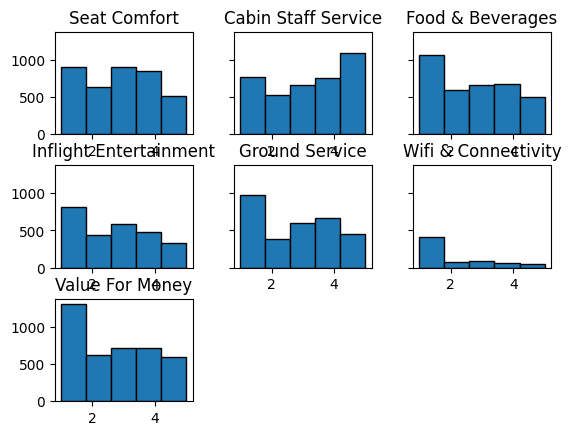

In [ ]:
# making histogram of the numeric values
df_clean[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
       'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity',
       'Value For Money']].hist(bins=5, sharey=True, grid=False,edgecolor = 'black')
plt.show()

In [133]:
# Used function to replace variable NaN with median of column
def replace_quant(data,col):
    
    val_replace = data[col].median()
    
     
    #replace missing value with mean based on column and country mean for that column
    data[col] = np.where(data[col].isna(),val_replace,data[col])
    missing = data[col].isnull().sum()
    return missing


#replace_quant(df_clean,'bunt')
replace_quant(df_clean,'Seat Comfort')
replace_quant(df_clean,'Food & Beverages')
replace_quant(df_clean,'Ground Service')
replace_quant(df_clean,'Value For Money')
replace_quant(df_clean,'Cabin Staff Service')

np.int64(0)

In [ ]:
# investingating inconsistencies in null values

# one review with no country residence, missing other demograohic data so may drop row
missing_country = df_clean[df_clean['country_residence'].isna()].index
df_clean.drop(missing_country,inplace=True)

# can remove demographic column now that needed data was extracted to protect reviewer data and privacy
#df_clean.drop('demographic',axis=1,inplace=True)


# three null for comment, need to tweak extract code as these are a mistake
df_clean['comment'].isna().sum()

# verified status, pre 2018 not verified was labelled as unverified misisng the extract, need to tweak extract code before analysis
# perhaps do search for unverified
df_clean[df_clean['verified'].isna()].head()
df_clean['verified'].isna().sum()
#df_clean['verified'].value_counts()

,rating,time,comment,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,Inflight Entertainment,Wifi & Connectivity,country_residence,verified
1815,7,2018-03-13,Two regular an uneventful flights. Curiously e...,NaN,Solo Leisure,Economy Class,Belfast to Lisbon via London,March 2018,3.0,4.0,1.0,4.0,2.0,no,NaN,NaN,Portugal,NaN
2237,1,2017-06-06,❎ Unverified | Rome to Heathrow. Having used ...,Boeing 767,Couple Leisure,Business Class,Rome to London Heathrow,May 2017,1.0,1.0,1.0,1.0,1.0,no,NaN,NaN,United Kingdom,NaN
2265,1,2017-05-17,❎ Unverified | London to Reykjavik. I can't r...,NaN,Family Leisure,Economy Class,London to Reykjavik,December 2016,3.0,NaN,3.0,1.0,1.0,no,NaN,NaN,United Kingdom,NaN
2272,1,2017-05-14,❎ Unverified | London to Hong Kong. The Avios...,NaN,Business,Economy Class,London to Hong Kong,April 2017,3.0,NaN,3.0,1.0,1.0,no,NaN,NaN,United Kingdom,NaN
2301,1,2017-05-03,❎ Unverified | I have always given fair revie...,Boeing 777 200,Business,Business Class,Bahrain to Dublin via london,May 2017,3.0,NaN,3.0,1.0,1.0,no,NaN,NaN,Bahrain,NaN


### Analysis of cleaned data

                          rating  Seat Comfort  Cabin Staff Service  \
rating                  1.000000      0.717348             0.723087   
Seat Comfort            0.717348      1.000000             0.593488   
Cabin Staff Service     0.723087      0.593488             1.000000   
Food & Beverages        0.687065      0.580420             0.663633   
Inflight Entertainment  0.557044      0.548258             0.463938   
Ground Service          0.644923      0.482690             0.474188   
Wifi & Connectivity     0.601032      0.558188             0.495784   
Value For Money         0.872429      0.678038             0.658594   

                        Food & Beverages  Inflight Entertainment  \
rating                          0.687065                0.557044   
Seat Comfort                    0.580420                0.548258   
Cabin Staff Service             0.663633                0.463938   
Food & Beverages                1.000000                0.550801   
Inflight Entertainme

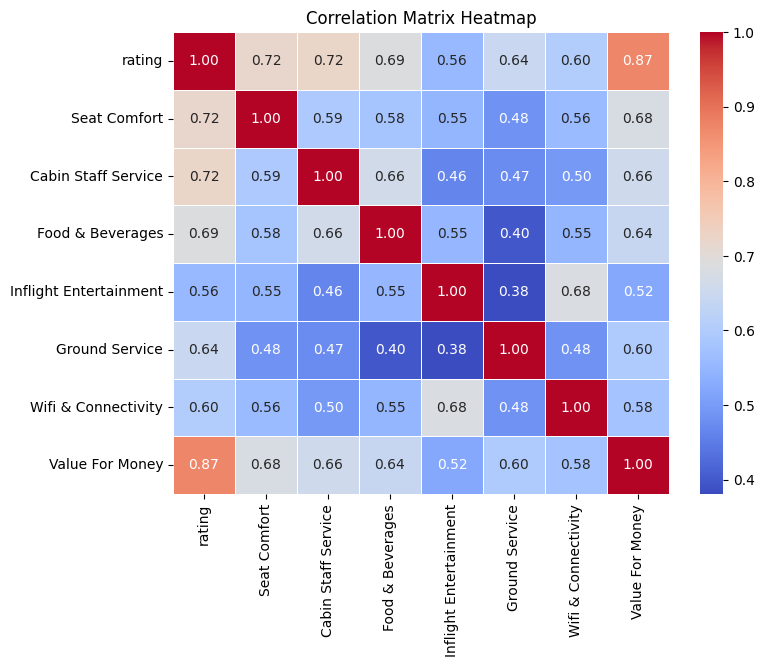

In [ ]:
# correlation matrix

# Calculate correlation matrix
correlation_matrix = df_clean[['rating','Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
       'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity',
       'Value For Money']].corr()
#print(correlation_matrix)

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Matrix Heatmap')
plt.show()

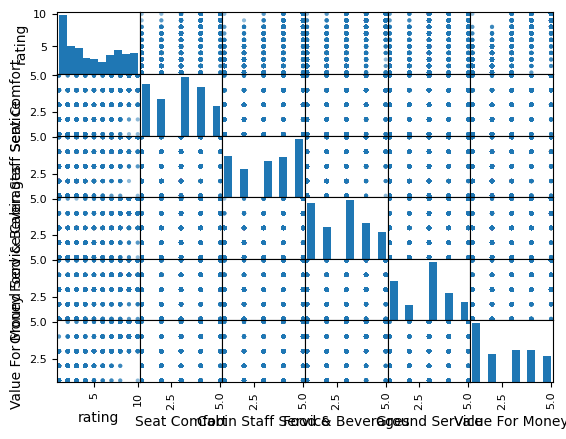

In [ ]:
# scatter matrix

from pandas.plotting import scatter_matrix

# selecting three numerical features
features = ['rating','Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
        'Ground Service',
       'Value For Money']
 
# plotting the scatter matrix
# with the features
scatter_matrix(df_clean[features])
plt.show()

In [ ]:
import re
from wordcloud import STOPWORDS

text = ' '.join(df_clean['comment'].astype(str).tolist())

text = re.sub(r'[^A-Za-z\s]', '', text)

text = text.lower()

stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

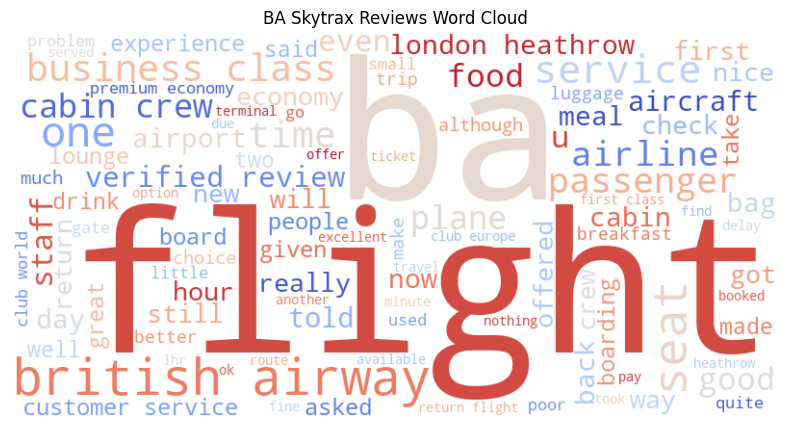

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, colormap='coolwarm').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("BA Skytrax Reviews Word Cloud")
plt.show()

## Data Modelling

Decision Tree to decide which factors most likely decide whether a customer will recommend

Are there any seasonal trends present within the data, does median rating change over time?

Are the median rating different fbetween the different Type of Traveller groups / Seat Type

Are Geographical differences in rating and customer satisfaction present. Do people residing in UK have different rating of BA than other country residences. 

Could feature engineer intl and domestic flight

Top ten popular routes (move to dataViz section) 

### Random Forest Classification of  Customer Recommendation

In [ ]:
df_ba = df_clean
ba_drop = ['Date Flown','time','Route','comment','Aircraft','Inflight Entertainment','Ground Service','Wifi & Connectivity','verified']
df_ba.drop(ba_drop,axis=1,inplace=True)

# renaming columns
col_names_ba = ['rating', 'type_of_traveller', 'seat_type', 'seat_comfort','cabin_staff_service','food_and_beverage','value_for_money','recommended','country_residence' ]
df_ba.columns = col_names_ba

In [ ]:
# replacing null values with the mode of each column
seat_type_mode = df_ba['seat_type'].mode()
df_ba['seat_type'].fillna(seat_type_mode,inplace=True)

C:\Users\logmy\AppData\Local\Temp\ipykernel_14328\304363819.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ba['Seat Type'].fillna(seat_type_mode,inplace=True)


In [ ]:
# replacing null values with the mode of each column
traveller_type_mode = df_ba['type_of_traveller'].mode()

df_ba['type_of_traveller'].fillna('Couple Leisure',inplace=True)

In [ ]:
# hot encode 'Type Of Traveller', 'Seat Type', 'country_residence'
le = preprocessing.LabelEncoder()
traveller_type_cat = le.fit_transform(df_ba.type_of_traveller)
seat_type_cat = le.fit_transform(df_ba.seat_type)
country_residence_cat = le.fit_transform(df_ba.country_residence)

# overwriting with the encoded categorical columns
df_ba['type_of_traveller'] = traveller_type_cat
df_ba['seat_type'] = seat_type_cat
df_ba['country_residence'] = country_residence_cat

In [ ]:
# mapping dummy variables to target variable recommended
df_ba['recommended'] = df_ba['recommended'].map({'no':0,'yes':1})

splitting the data into features(x) and target (y)

In [172]:
# split the data into features (X) and target (y)
X = df_ba.drop('recommended', axis=1)
y = df_ba['recommended']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [ ]:
clf = RandomForestClassifier().fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {0:.2f}'.format(accuracy))

Accuracy: 0.9453621346886912


In [169]:

df_ba.head(3)

,rating,type_of_traveller,seat_type,seat_comfort,cabin_staff_service,food_and_beverage,value_for_money,recommended,country_residence
1,6,1,1,4.0,4.0,2.0,5.0,yes,1
2,4,1,1,3.0,2.0,3.0,2.0,no,71
3,8,1,1,4.0,5.0,4.0,4.0,yes,72
